## Imports & Setup

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer_2 import *
from architecture.AutoEncoder_2 import *

In [11]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [12]:
torch.manual_seed(43)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [14]:
size = 128
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [16]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)
len(train_data)

4686

In [17]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)
len(test_data)

585

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[2830, 3569, 4171, 642, 1297, 181, 4578, 3949, 3299]


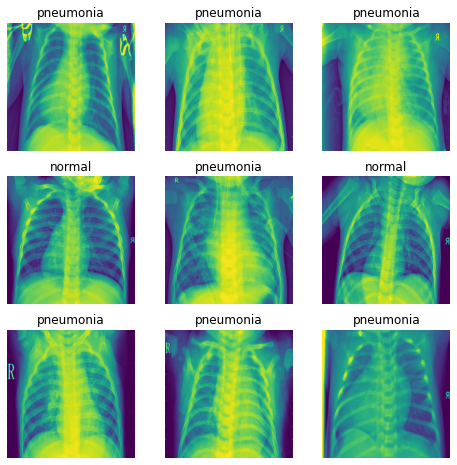

In [9]:
visualize_data(train_data)

[111, 414, 80, 127, 99, 103, 32, 252, 484]


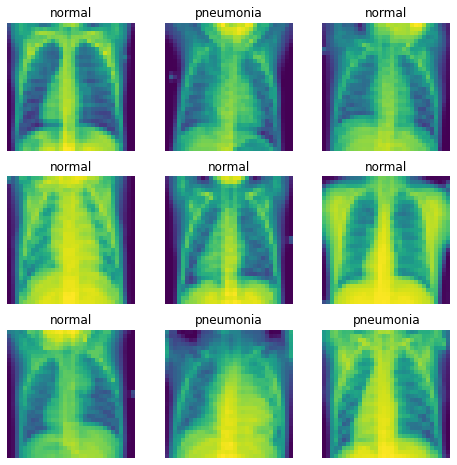

In [10]:
visualize_data(test_data)

## Load AutoEncoder

In [11]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [12]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256")["model_state_dict"])

<All keys matched successfully>

In [13]:
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

In [14]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False, weight_decay=1e-5):
    return optim.Adam(model.parameters(), amsgrad=amsgrad, betas=betas, lr=lr, weight_decay=weight_decay)

In [15]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]
dropout=0.3

In [16]:
model = Transformer(hidden, kernel_size, window, blocks,dropout=dropout).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=2592, out_fe

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [18]:
optimizer = create_adam_optimizer(model, lr = 0.01)

In [49]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 3, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/3, Batch number: 0, Cumulated accuracy: 0.84375
Epoch 1/3, Batch number: 5, Cumulated accuracy: 0.80859375
Epoch 1/3, Batch number: 10, Cumulated accuracy: 0.8075284090909091
Epoch 1/3, Batch number: 15, Cumulated accuracy: 0.8046875
Epoch 1/3, Batch number: 20, Cumulated accuracy: 0.8035714285714286
Epoch 1/3, Batch number: 25, Cumulated accuracy: 0.8106971153846154
Epoch 1/3, Batch number: 30, Cumulated accuracy: 0.8157762096774194
Epoch 1/3, Batch number: 35, Cumulated accuracy: 0.81640625
--- Epoch 1/3: Train loss: 0.4564, Train accuracy: 0.8154
--- Epoch 1/3: Val loss: 0.3359, Val accuracy: 0.8786
Epoch 2/3, Batch number: 0, Cumulated accuracy: 0.8359375
Epoch 2/3, Batch number: 5, Cumulated accuracy: 0.8072916666666666
Epoch 2/3, Batch number: 10, Cumulated accuracy: 0.8153409090909091
Epoch 2/3, Batch number: 15, Cumulated accuracy: 0.81494140625
Epoch 2/3, Batch number: 20, Cumulated accuracy: 0.8132440476190477
Epoch 2/3, Batch number: 25, Cumulated accuracy: 0.8143028

## Hyperparam Tuning

In [17]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

lr=0.01

lr_list=[0.01,0.005,0.001]

kernel_list=[3,5,7]

window_list=[2,3,5]

blocks_list=[[flattened, 512, 64], [flattened, 512, 256, 64], [flattened, 512, 128, 64]]

weight_decay=1e-5

hidden_list=[ [256, 256, 64, 32], [256,128,64,32]]

dropout_list=[0.3,0.5,0.7]

In [18]:
test_param="dropout"
test_losses = []
test_accuracies = []
precision_list=[]
recall_list=[]
f1_list=[]
epochs=10

for dropout in dropout_list:
    print(test_param+'='+str(dropout))
    new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
    channels = hidden[-1]
    changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )
    flattened = channels*changed_img*changed_img
    blocks[0]=flattened
    
    
    model = Transformer( hidden=hidden, kernel_size=kernel_size,
                  window=window, blocks=blocks,dropout=dropout).to(device)
    
    
   
    optimizer = create_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
    
    tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = epochs, autoencoder=autoencmodel)
    true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)
    p,r,f= return_metrics(true_labels, model_preds)
                           
    test_losses+=[test_loss]
    test_accuracies+=[test_accuracy]
    precision_list+=[p]
    recall_list+=[r]
    f1_list+=[f]

dropout=0.3
Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.515625
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.5182291666666666
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.5553977272727273
Epoch 1/10, Batch number: 15, Cumulated accuracy: 0.58447265625
Epoch 1/10, Batch number: 20, Cumulated accuracy: 0.6026785714285714
Epoch 1/10, Batch number: 25, Cumulated accuracy: 0.6162860576923077
Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.6302923387096774
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.6438802083333334
--- Epoch 1/10: Train loss: 0.6494, Train accuracy: 0.6455
--- Epoch 1/10: Val loss: 0.4879, Val accuracy: 0.7897
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.765625
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.7330729166666666
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.7528409090909091
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.767578125
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.7645089285714286
Epoch 2/10, B

Epoch 3/10, Batch number: 35, Cumulated accuracy: 0.7497829861111112
--- Epoch 3/10: Train loss: 0.5491, Train accuracy: 0.7495
--- Epoch 3/10: Val loss: 0.4787, Val accuracy: 0.8034
Epoch 4/10, Batch number: 0, Cumulated accuracy: 0.765625
Epoch 4/10, Batch number: 5, Cumulated accuracy: 0.7669270833333334
Epoch 4/10, Batch number: 10, Cumulated accuracy: 0.7748579545454546
Epoch 4/10, Batch number: 15, Cumulated accuracy: 0.77685546875
Epoch 4/10, Batch number: 20, Cumulated accuracy: 0.7645089285714286
Epoch 4/10, Batch number: 25, Cumulated accuracy: 0.7602163461538461
Epoch 4/10, Batch number: 30, Cumulated accuracy: 0.758820564516129
Epoch 4/10, Batch number: 35, Cumulated accuracy: 0.7569444444444444
--- Epoch 4/10: Train loss: 0.5262, Train accuracy: 0.7571
--- Epoch 4/10: Val loss: 0.4618, Val accuracy: 0.7966
Epoch 5/10, Batch number: 0, Cumulated accuracy: 0.8046875
Epoch 5/10, Batch number: 5, Cumulated accuracy: 0.7825520833333334
Epoch 5/10, Batch number: 10, Cumulated ac

Epoch 6/10, Batch number: 20, Cumulated accuracy: 0.6997767857142857
Epoch 6/10, Batch number: 25, Cumulated accuracy: 0.6986177884615384
Epoch 6/10, Batch number: 30, Cumulated accuracy: 0.7003528225806451
Epoch 6/10, Batch number: 35, Cumulated accuracy: 0.7000868055555556
--- Epoch 6/10: Train loss: 0.5940, Train accuracy: 0.7004
--- Epoch 6/10: Val loss: 0.5343, Val accuracy: 0.7829
Epoch 7/10, Batch number: 0, Cumulated accuracy: 0.7109375
Epoch 7/10, Batch number: 5, Cumulated accuracy: 0.7109375
Epoch 7/10, Batch number: 10, Cumulated accuracy: 0.7109375
Epoch 7/10, Batch number: 15, Cumulated accuracy: 0.7197265625
Epoch 7/10, Batch number: 20, Cumulated accuracy: 0.7224702380952381
Epoch 7/10, Batch number: 25, Cumulated accuracy: 0.7268629807692307
Epoch 7/10, Batch number: 30, Cumulated accuracy: 0.7273185483870968
Epoch 7/10, Batch number: 35, Cumulated accuracy: 0.7298177083333334
--- Epoch 7/10: Train loss: 0.5591, Train accuracy: 0.7290
--- Epoch 7/10: Val loss: 0.4457, 

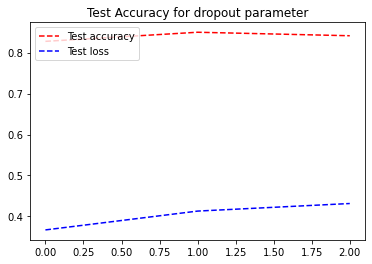

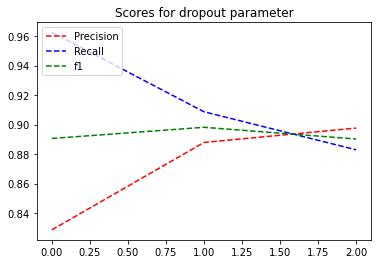

In [19]:
plt.plot(test_accuracies, "r--", label='Test accuracy')
plt.plot(test_losses, "b--", label='Test loss')
plt.title(f'Test Accuracy for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

plt.plot(precision_list, "r--", label='Precision')
plt.plot(recall_list, "b--", label='Recall')
plt.plot(f1_list, "g--", label='f1')
plt.title(f'Scores for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

In [ ]:
print(f'test accuracy: {test_accuracies}')
print(f'test loss: {test_losses}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'f1 score: {f1_list}')

test accuracy: [0.8273504273504273, 0.8495726495726496, 0.841025641025641]
test loss: [0.36721000969409945, 0.41315754055976867, 0.4316329598426819]
precision: [0.8286290322580645, 0.8878718535469108, 0.8976190476190476]
recall: [0.9625292740046838, 0.9086651053864169, 0.882903981264637]
f1 score: [0.8905742145178764, 0.8981481481481483, 0.8902007083825266]


## Testing Model & Performance Curves

In [50]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.3519, Test accuracy: 0.8701


Precision: 0.8926174496644296
Recall: 0.9344262295081968
F1 score: 0.9130434782608696


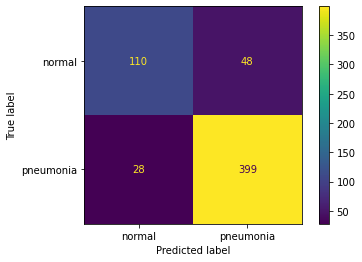

In [51]:
show_metrics(true_labels, model_preds)

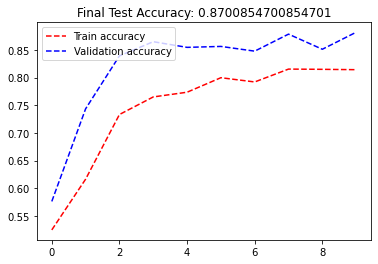

In [52]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

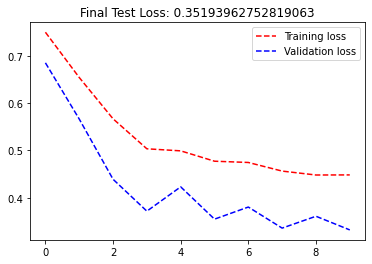

In [53]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [54]:
test_loader2 = produce_loader(test_data, 1)

In [55]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencmodel)

Precision: 0.9078014184397163
Recall: 0.8992974238875878
F1 score: 0.9035294117647058


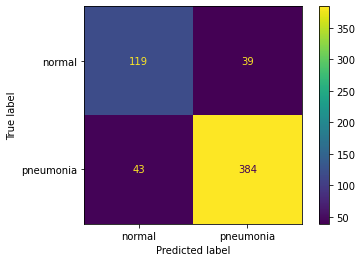

In [56]:
show_metrics(true_labels2, model_preds2)

[109, 270, 453, 172, 213, 133, 457, 83, 137, 47, 149, 127, 394, 349, 500, 76, 158, 213, 308, 145, 130, 133, 366, 134, 79]


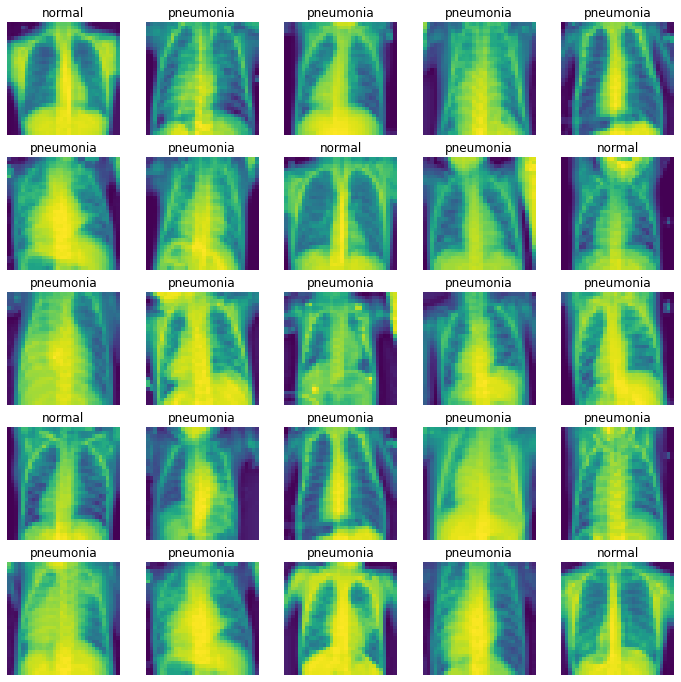

In [57]:
visualize_data(correct_list, (12,12), 5)

[57, 66, 38, 2, 66, 3, 52, 48, 1, 53, 5, 57, 45, 47, 22, 33, 64, 19, 23, 78, 33, 49, 70, 38, 46]


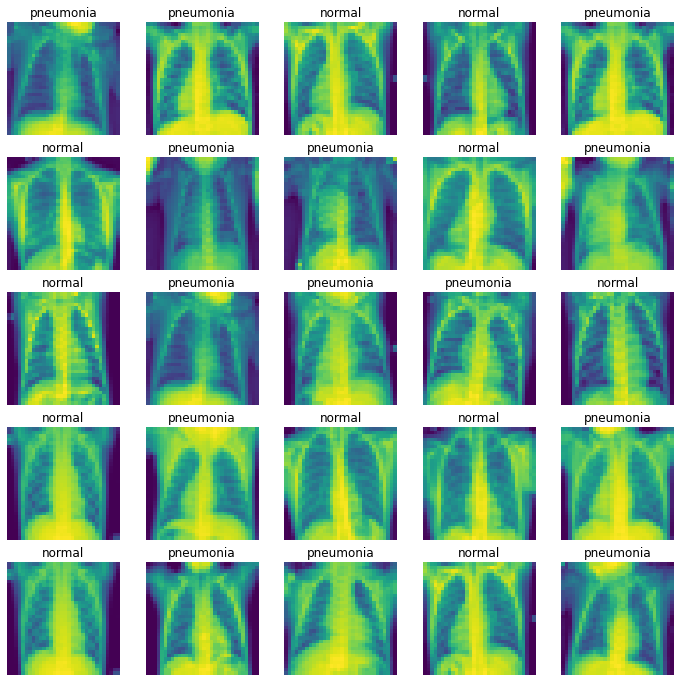

In [58]:
visualize_data(wrong_list, (12,12), 5)

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './Transformer_10epochs')